In [9]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import json
import joblib
import os

In [2]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/194726
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# Set HDFS paths for the datasets
traffic_trainset_path = 'traffic_trainset_hour.csv'
weather_trainset_path = 'weather_trainset.csv'
traffic_testset_path = 'traffic_testset.csv'
weather_testset_path = 'weather_testset.csv'

# Load datasets
traffic_train = pd.read_csv(traffic_trainset_path)
weather_train = pd.read_csv(weather_trainset_path)
traffic_test = pd.read_csv(traffic_testset_path)
weather_test = pd.read_csv(weather_testset_path)

In [4]:
# Join training datasets on ['day', 'hour']

training_data = pd.merge(traffic_train, weather_train, on=['day', 'hour'])

# Join test datasets on ['day', 'hour']

test_data = pd.merge(traffic_test, weather_test, on=['day', 'hour'])

<Axes: >

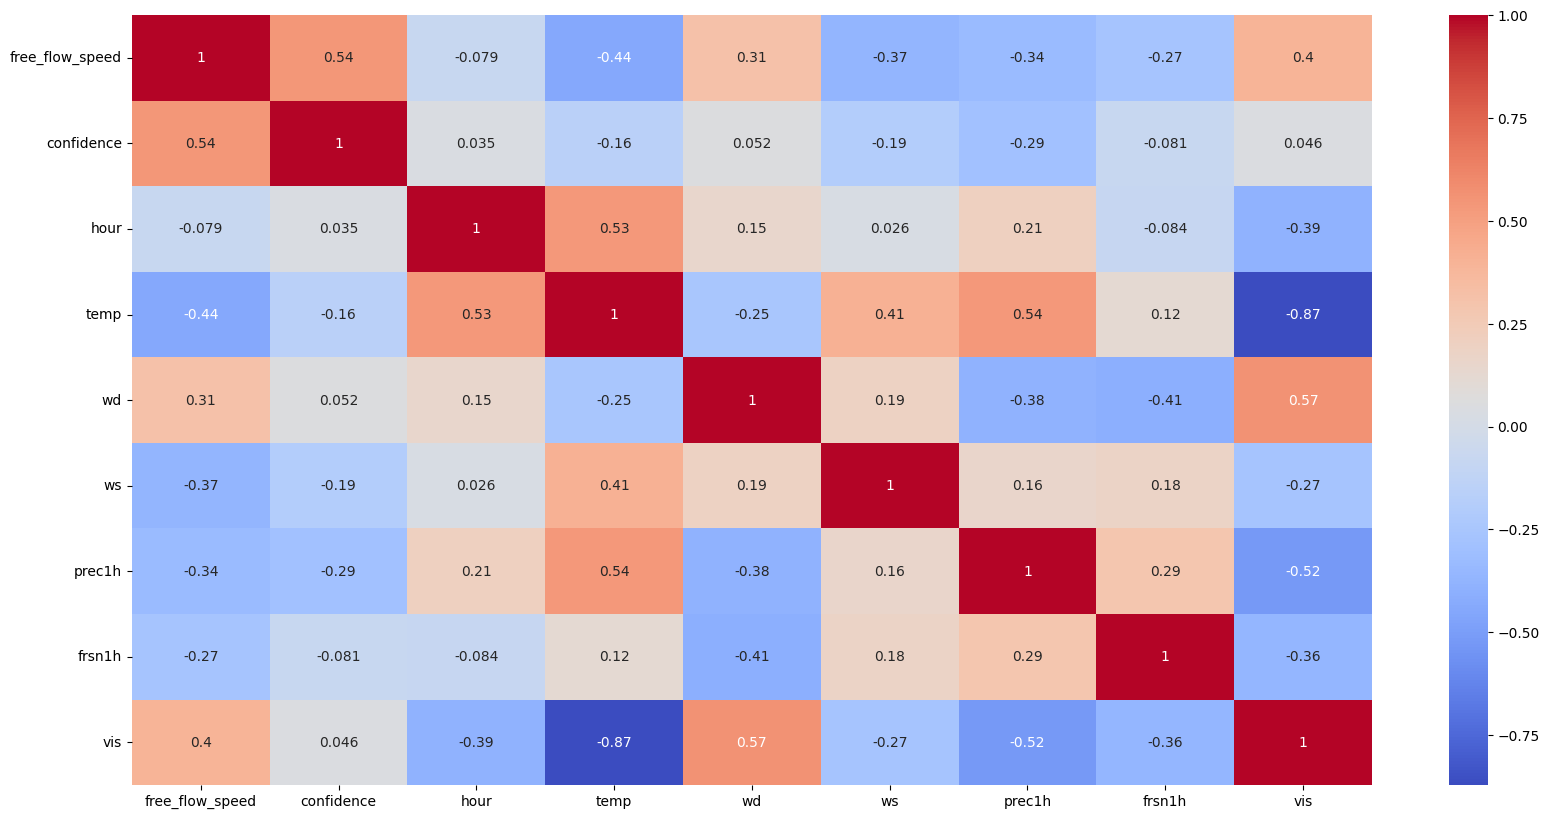

In [15]:
a_colums = training_data.drop(['weekend','day','current_speed'], axis=1)
corr = a_colums.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')

In [16]:
# Split data into features (X) and target variable (y)

X_train = training_data.drop(['day','current_speed'], axis=1)
y_train = training_data['current_speed']

X_test = test_data.drop(['day','current_speed'], axis=1)
y_test = test_data['current_speed']

In [17]:
# Model training and evaluation

# K-Nearest Neighbors
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
knn_rmse = mean_squared_error(y_test, knn_predictions, squared=False)
knn_r2 = r2_score(y_test, knn_predictions)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_rmse = mean_squared_error(y_test, lr_predictions, squared=False)
lr_r2 = r2_score(y_test, lr_predictions)

# AdaBoost Regression
ada_model = AdaBoostRegressor()
ada_model.fit(X_train, y_train)
ada_predictions = ada_model.predict(X_test)
ada_rmse = mean_squared_error(y_test, ada_predictions, squared=False)
ada_r2 = r2_score(y_test, ada_predictions)

# XGBoost Regression
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
xgb_r2 = r2_score(y_test, xgb_predictions)

In [18]:
# Model comparison

model_metrics = pd.DataFrame({
    'Model': ['KNN', 'Linear Regression', 'AdaBoost Regression', 'XGBoost Regression'],
    'RMSE': [knn_rmse, lr_rmse, ada_rmse, xgb_rmse],
    'R2 Score': [knn_r2, lr_r2, ada_r2, xgb_r2]
})

best_model = model_metrics.loc[model_metrics['RMSE'].idxmin()]

print("Model Comparison:")
print(model_metrics)
print("\nBest Model:")
print(best_model)

Model Comparison:
                 Model      RMSE  R2 Score
0                  KNN  3.259601  0.600287
1    Linear Regression  3.954991  0.411550
2  AdaBoost Regression  3.315788  0.586389
3   XGBoost Regression  3.629154  0.504516

Best Model:
Model            KNN
RMSE        3.259601
R2 Score    0.600287
Name: 0, dtype: object


In [19]:
# Save the KNN model and performance metrics to a directory
mr = project.get_model_registry()

# Create a directory for the model
model_dir="traffic_weather_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save KNN model
knn_model_path = model_dir + '/knn_model.joblib'
joblib.dump(knn_model, knn_model_path)

# Save performance metrics
metrics_path = model_dir + '/model_metrics.json'
model_metrics.to_json(metrics_path, orient='records')

print("Model and metrics saved to:", model_dir)


Connected. Call `.close()` to terminate connection gracefully.
Model and metrics saved to: traffic_weather_model


In [20]:
# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry

traffic_weather_model = mr.python.create_model(
    name="traffic_weather_model", 
    metrics={
        'RMSE': float(best_model['RMSE']),
        'R2 Score': float(best_model['R2 Score'])},
    model_schema=model_schema,
    description="Traffic Flow Predictor"
)
             
             
# Upload the model to the model registry, including all files in 'model_dir'
traffic_weather_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/284 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/10390 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/867 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/194726/models/traffic_weather_model/2


Model(name: 'traffic_weather_model', version: 2)